[View in Colaboratory](https://colab.research.google.com/github/yepuv1/tensorflow/blob/master/NandGate.ipynb)

In [0]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

In [0]:
def nand(a, b):
  return np.logical_not(np.logical_and(a,b))

In [0]:
def generate_nand_data(examples_size, seed=1):
  
  assert(examples_size >= 4)
  nand_input = np.array([[0,0],[0,1],[1,0],[1,1]], np.bool)
  
  features_size = 2
  examples_size = examples_size - examples_size % 4
  partition_size = np.int32(examples_size / 4)

  X = np.zeros(shape=(features_size,examples_size), dtype=np.int32)
  Y = np.zeros(shape=(1,examples_size), dtype=np.int32)
  
  for i in range(0,4):
    s, e = (partition_size*i, partition_size*(i+1) )
    X[:,s:e] = X[:,s:e] + nand_input[i].reshape(1,2).T
  
  Y = nand(X[0,:], X[1,:]).astype(np.int32).reshape(1,examples_size)
  
  return X, Y

In [0]:
def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    
    C = tf.constant(dtype=tf.int32, name="C", value=C)
    one_hot_matrix = tf.one_hot(labels,depth=C, axis=0)
    with tf.Session() as sess:
      one_hot = sess.run(one_hot_matrix)
   
    return one_hot

In [0]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of input vector 
    n_y -- scalar, number of classes (from 0 to 1, so -> 2)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    X = tf.placeholder(tf.float32, shape=(n_x, None))
    Y = tf.placeholder(tf.float32, shape=(n_y, None))

    
    return X, Y

In [0]:
def initialize_parameters(dic_of_layer_sizes):
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 2]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1) 
        
    
    parameters ={}
    for key, value in dic_of_layer_sizes.items():
      print(key)
      print(value)
      parameters[key]=tf.get_variable(key, value, initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    
    
    return parameters

In [0]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR ->  SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
              
    Z1 = tf.add(tf.matmul(W1, X), b1)  # LINEAR                                         
    A1 = tf.nn.relu(Z1)                # RELU                           
    Z2 = tf.add(tf.matmul(W2, A1), b2) # LINEAR                                           

    return Z2

In [0]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    
    return cost

In [0]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [0]:
def model(X_train, Y_train, X_test, Y_test,dic_of_layer_sizes,learning_rate = 0.0001,
          num_epochs = 1024, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    dic_of_layer_sizes - dictionary of W<n> b<n> sizes as [x,y]
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters(dic_of_layer_sizes)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X=X, parameters=parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Y=Y,Z3=Z3)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

number of training examples = 40000
number of test examples = 8
X_train shape: (2, 40000)
Y_train shape: (2, 40000)
X_test shape: (2, 8)
Y_test shape: (2, 8)
W1
[8, 2]
b1
[8, 1]
W2
[2, 8]
b2
[2, 1]
Cost after epoch 0: 0.836004
Cost after epoch 100: 0.350047
Cost after epoch 200: 0.112368
Cost after epoch 300: 0.024663
Cost after epoch 400: 0.004635
Cost after epoch 500: 0.000818
Cost after epoch 600: 0.000139
Cost after epoch 700: 0.000023
Cost after epoch 800: 0.000004
Cost after epoch 900: 0.000001
Cost after epoch 1000: 0.000000
Cost after epoch 1100: 0.000000
Cost after epoch 1200: 0.000000
Cost after epoch 1300: 0.000000
Cost after epoch 1400: 0.000000
Cost after epoch 1500: 0.000000
Cost after epoch 1600: 0.000000
Cost after epoch 1700: 0.000000
Cost after epoch 1800: 0.000000
Cost after epoch 1900: 0.000000
Cost after epoch 2000: 0.000000
Cost after epoch 2100: 0.000000
Cost after epoch 2200: 0.000000
Cost after epoch 2300: 0.000000
Cost after epoch 2400: 0.000000
Cost after epo

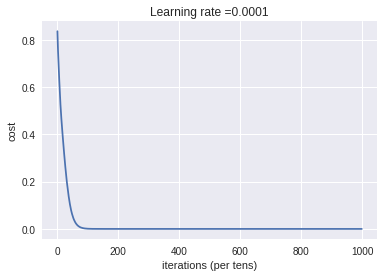

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 1.0


In [32]:
training_size = 4*10000
test_size = 4*2
X_train, Y_train = generate_nand_data(training_size)
Y_train = one_hot_matrix(Y_train.reshape(training_size), 2)
X_test, Y_test = generate_nand_data(test_size)
Y_test = one_hot_matrix(Y_test.reshape(test_size), 2)


print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

dic_of_layer_sizes ={
    "W1":[8,2],
    "b1":[8,1],
    "W2":[2,8],
    "b2":[2,1]
}

parameters = model(
    X_train, 
    Y_train, 
    X_test, 
    Y_test, 
    dic_of_layer_sizes, 
    num_epochs=5000,
    minibatch_size=1024
)

In [0]:
X, Y = generate_nand_data(2*4)

In [27]:
with tf.Session() as session:
 X = np.float32(X)
 z3 = forward_propagation(np.float32(X), parameters)
 p = tf.argmax(z3)
 print(X)
 print(session.run(p))

[[0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 0. 0. 1. 1.]]
[1 1 1 1 1 1 0 0]
